In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/AML Project Group 20')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This notebook is partially different from DNN.ipynb. This notebook Trains a regression neural network for predicting the value of ratings (as opposed to the classification approach in DNN.ipynb) . Based on these predicted values, recommendations are made to the user.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Embedding, Dense, Dropout, BatchNormalization, Concatenate, Flatten
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter

In [5]:
data_dir = 'ml-25m/'
movies_df = pd.read_csv(data_dir + 'movies.csv')
ratings_df = pd.read_csv(data_dir + 'ratings.csv')

In [6]:
#INPUT
uid, top_n = 350, 15

**Ratings Data File Structure (ratings.csv)**

Each line of this file after the header row represents one rating of one movie by one user, and has the following format:  

- The lines within this file are ordered first by userId, then, within user, by movieId.
- Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
- Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [ ]:
ratings_df.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [ ]:
len(ratings_df)

25000095

In [7]:
# use a subset to train DNN model
ratings_df1 = ratings_df[ratings_df.userId < 2000]

In [ ]:
len(ratings_df1)

287678

**Movies Data File Structure (movies.csv)**  

Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

- Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

- Genres are a pipe-separated list, and are selected from the following: Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
(no genres listed)

In [ ]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [8]:
movies_df1 = movies_df[['movieId','title']]
movies_df1.head(3)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)


In [9]:
merged_df = pd.merge(ratings_df1, movies_df1, how='inner', on='movieId')
merged_df.head(3)

,userId,movieId,rating,timestamp,title
0,1,296,5.0,1147880044,Pulp Fiction (1994)
1,3,296,5.0,1439474476,Pulp Fiction (1994)
2,4,296,4.0,1573938898,Pulp Fiction (1994)


In [ ]:
len(merged_df)

287678

In [10]:
user_encoder, movie_encoder = LabelEncoder(), LabelEncoder()
merged_df['uid_enc'] = user_encoder.fit_transform(merged_df['userId'].values)
merged_df['mid_enc'] = movie_encoder.fit_transform(merged_df['movieId'].values)

In [11]:
X = merged_df[['uid_enc', 'mid_enc']].values
y = merged_df['rating'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(230142, 2) (57536, 2) (230142,) (57536,)


In [14]:
merged_df.head()

,userId,movieId,rating,timestamp,title,uid_enc,mid_enc
0,1,296,5.0,1147880044,Pulp Fiction (1994),0,278
1,3,296,5.0,1439474476,Pulp Fiction (1994),2,278
2,4,296,4.0,1573938898,Pulp Fiction (1994),3,278
3,5,296,4.0,830786155,Pulp Fiction (1994),4,278
4,7,296,4.0,835444730,Pulp Fiction (1994),6,278


In [12]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
# scale to 1-10
# y_train_array = 2 * y_train - 1
# y_val_array = 2 * y_val - 1

In [13]:
num_users = merged_df['uid_enc'].nunique()
num_movies = merged_df['mid_enc'].nunique()
embedding_size = 5

In [25]:
dropout_rate = 0.2
u_emb_input = Input(shape=(1,))
m_emb_input = Input(shape=(1,))

u_emb = Embedding(
    num_users, 
    embedding_size)(u_emb_input)

u_emb = Flatten()(u_emb)

m_emb = Embedding(
    num_movies, 
    embedding_size)(m_emb_input)

m_emb = Flatten()(m_emb)

concat = Concatenate()([u_emb,m_emb])

concat = Dropout(dropout_rate)(concat)

layer1 = Dense(64, activation='relu')(concat)
layer1 = BatchNormalization()(layer1)
layer1 = Dropout(dropout_rate)(layer1)

layer2 = Dense(32, activation='relu')(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Dropout(dropout_rate)(layer2)

out = Dense(1)(layer2)

model = Model(inputs=[u_emb_input,m_emb_input], outputs=out)


In [15]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 5)         9995        ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 5)         72260       ['input_8[0][0]']                
                                                                                            

We create a custom metric which is the equivalent of R2 score as accuracy is not a suitable metric for regression problems.

In [21]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])

In [27]:
from keras.optimizers import SGD
model.compile(
    optimizer="Adam",
    loss='mean_squared_error',
    metrics=[coeff_determination])

history = model.fit(
    x = X_train_array,
    y = y_train, 
    batch_size=128, 
    epochs=30, 
    verbose=1, 
    validation_data=(X_val_array, y_val), 
    shuffle=True, 
    )

Epoch 1/30
1798/1798 [==============================] - 12s 6ms/step - loss: 2.4494 - coeff_determination: -1.2154 - val_loss: 0.9054 - val_coeff_determination: 0.1896
Epoch 2/30
1798/1798 [==============================] - 11s 6ms/step - loss: 1.0222 - coeff_determination: 0.0871 - val_loss: 0.8037 - val_coeff_determination: 0.2799
Epoch 3/30
1798/1798 [==============================] - 10s 6ms/step - loss: 0.8980 - coeff_determination: 0.1967 - val_loss: 0.7693 - val_coeff_determination: 0.3102
Epoch 4/30
1798/1798 [==============================] - 10s 6ms/step - loss: 0.8422 - coeff_determination: 0.2474 - val_loss: 0.7591 - val_coeff_determination: 0.3191
Epoch 5/30
1798/1798 [==============================] - 10s 6ms/step - loss: 0.8040 - coeff_determination: 0.2809 - val_loss: 0.7505 - val_coeff_determination: 0.3274
Epoch 6/30
1798/1798 [==============================] - 10s 6ms/step - loss: 0.7783 - coeff_determination: 0.3039 - val_loss: 0.7451 - val_coeff_determination: 0.33

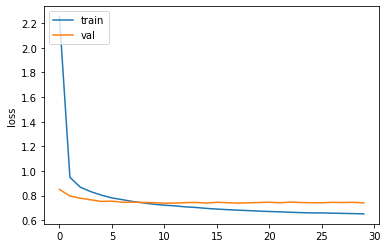

In [78]:
hist = pd.DataFrame(history.history)
fig, ax = plt.subplots()
ax.plot(hist.index, hist['loss'])
ax.plot(hist.index, hist['val_loss'])
ax.set_ylabel('loss')
ax.legend(["train", "val"], loc="upper left")
# ax2 = ax.twinx()
# ax2.plot(hist.index, hist['accuracy'], 'r--')
# ax2.plot(hist.index, hist['val_accuracy'], 'b--')
# ax2.set_ylabel('accuracy')
# ax2.legend(["train", "val"], loc="upper right")
# ax.set_xlabel('epochs')

In [82]:
watched = list(merged_df[merged_df.userId == uid]['mid_enc'])
unwatched = [i for i in range(min(merged_df['mid_enc']), max(merged_df['mid_enc']) + 1) if i not in watched]

In [83]:
encoded_uid = user_encoder.transform([uid])
user_movie_array = [np.asarray(
    list(encoded_uid) * len(unwatched)), 
    np.asarray(unwatched)
    ]

In [84]:
# probability of each possible rating from 0.5 to 5
pred_ratings = model.predict(user_movie_array)

# use index to represent rating value
pred_ratings = pred_ratings.argmax(1)

# indices that sort the array by ascending order
sorted_movie_indices = pred_ratings.argsort()

# reverse indices to get top rated movies
recommended_movie_indices = sorted_movie_indices[::-1]

450/450 [==============================] - 1s 2ms/step


In [94]:
user_movie_watched = [np.asarray(
    list(encoded_uid) * len(watched)), 
    np.asarray(watched)
    ]

In [96]:
pred_ratings_watched = model.predict(user_movie_watched)

3/3 [==============================] - 0s 4ms/step


In [98]:
pred_ratings_w = [i.round() for i in pred_ratings_watched[:,0]]

In [101]:
actual_ratings_w=list(merged_df[merged_df.userId == uid]['rating'])

In [105]:
sum=0
for i in range(len(watched)):
  if(pred_ratings_w[i]==actual_ratings_w[i]):
    sum+=1
print("Accuracy:",sum*100/len(watched))

Accuracy: 60.526315789473685


In [110]:
predictions = model.predict(X_val_array[:15])
print([predictions])
print(y_val[0:15])
# [print(predictions[i], y_val[i]) for i in range(0,15)]

1798/1798 [==============================] - 3s 2ms/step
[array([[3.2926059],
       [3.9882421],
       [4.3392353],
       ...,
       [3.56068  ],
       [3.6103427],
       [3.2938323]], dtype=float32)]
[4.  4.  5.  3.  4.  2.5 4.5 4.  4.5 4.  4.  2.  4.  3.  4. ]


In [85]:
recommended_movies_ids = movie_encoder.inverse_transform(recommended_movie_indices)

# list top n recommendations
for i in range(top_n):
  print(movies_df1[movies_df1.movieId==recommended_movies_ids[i]].title.values.item())

The Lighthouse (2019)
Pride of the Yankees, The (1942)
Modern Romance (1981)
Modern Problems (1981)
Teddy Bear (Mis) (1981)
Madman (1981)
Looney, Looney, Looney Bugs Bunny Movie, The (1981)
Looker (1981)
Legend of the Lone Ranger, The (1981)
Ladies and Gentlemen, the Fabulous Stains (a.k.a. All Washed Up) (1981)
Who Pulled the Plug? (Göta kanal eller Vem drog ur proppen?) (1981)
Gregory's Girl (1981)
Ghost Story (1981)
Inquisitor, The (a.k.a. Under Suspicion) (Garde à vue) (1981)
Gallipoli (1981)
